In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import image.loadImage as loadImage
import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing
import image.modelsCNN as modelsCNN

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors
from sklearn.preprocessing import MinMaxScaler
import anndata as ad
from sklearn.metrics import pairwise_distances

In [3]:
import scipy.stats

In [4]:

plaqueMaskName='PlaqueMask6'
olddata=scanpy.read_h5ad('/home/xinyiz/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
plot_samples_old={'disease13old':'AD_mouse9494','control13old':'AD_mouse9498','disease8old':'AD_mouse9723','control8old':'AD_mouse9735'}


In [5]:
datadir='/mnt/external_ssd/xinyi/starmap_new/2022-06-14-Xinyi-mAD/'

gaeClusterPath='/mnt/external_ssd/xinyi/plots/train_gae_starmap/allk20XA_02_dca_over/newold/combinedlogminmax_beforeAct/cluster/leiden_nn10mdist025n_pcs40res0.082epoch9990'
with open(gaeClusterPath, 'rb') as input:
    gaeclusterlabels = pickle.load(input)

plot_samples={'disease13old':'ADmouse_9494','control13old':'ADmouse_9498','disease8old':'ADmouse_9723','control8old':'ADmouse_9735','disease13':'ADmouse_11346','control13':'ADmouse_11351','disease8':'ADmouse_9723_2','control8':'ADmouse_9707'}


gaeCoord=None
sampleNames=None
scaleddata=scanpy.read_h5ad(datadir+'/2022-04-06-Hu-AD-stardist-scaled.h5ad')
for s in plot_samples.keys():
    if 'old' in s:
        sampleidx_s=plot_samples_old[s]
        if gaeCoord is None:
            gaeCoord=olddata.obs.loc[olddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()/0.3
            sampleNames=np.repeat(s,np.sum(olddata.obs['sample']==sampleidx_s))
        else:
            gaeCoord=np.concatenate((gaeCoord,olddata.obs.loc[olddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()/0.3),axis=0)
            sampleNames=np.concatenate((sampleNames,np.repeat(s,np.sum(olddata.obs['sample']==sampleidx_s))),axis=None)
    else:
        sampleidx_s=plot_samples[s]
        if gaeCoord is None:
            gaeCoord=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()
            sampleNames=np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))
        else:
            gaeCoord=np.concatenate((gaeCoord,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()),axis=0)
            sampleNames=np.concatenate((sampleNames,np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))),axis=None)
# gaeCoord=(gaeCoord/0.3).astype(int)
feature_names=scaleddata.var.index
feature_names=feature_names.astype(str)


In [35]:
oldd8coord=olddata.obs.loc[olddata.obs['sample']==plot_samples_old['disease8old'],['y','x']].to_numpy()

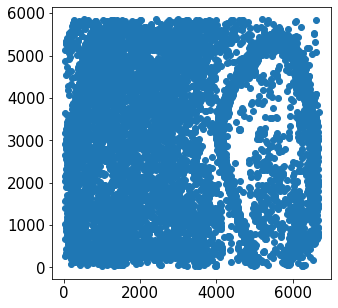

In [39]:
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(oldd8coord[:,0],oldd8coord[:,1])

In [36]:
newd8coord=scaleddata.obs.loc[scaleddata.obs['sample']==plot_samples['disease8old'],['y','x']].to_numpy()



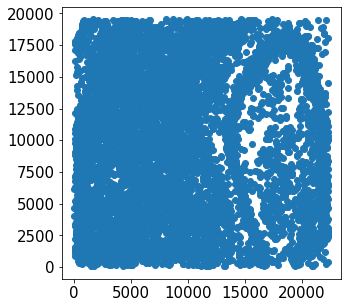

In [41]:
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(newd8coord[:,0],newd8coord[:,1])

In [6]:
#reproduce the main figure result on the new data
plaqueMaskImg='Mask of plaque'

diamThresh_mul=800
minThresh_mul=12
overlap=int(diamThresh_mul*0.7)
areaThresh=diamThresh_mul*diamThresh_mul*0.7


sampleidx={'disease13':'ADmouse_11346','control13':'ADmouse_11351','disease8':'ADmouse_9723_2','control8':'ADmouse_9707'}
cellCoord={}
for s in sampleidx.keys():
    sampleidx_s=sampleidx[s] 
    cellCoord[s]=((scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy())).astype(int)


labellist={}
for s in sampleidx.keys():
    print(s)
    
    if 'disease' in s:
        plaqueMaskImg_s=plaqueMaskImg+'_'+s+'new.tif'
    elif 'control' in s:
        continue
    labellist[s]=loadImage.load_cellCentroid_plaqueOnly(plaqueMaskImg_s,cellCoord[s],sampleidx[s],os.path.join(datadir,'plaqueDistr'),diamThresh_mul,ifFlip=False,seed=3,imagename='pi_sum.tif',minmaxscale=True,nchannels=1)


disease13
control13
disease8
control8


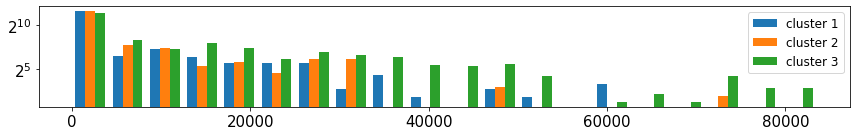

In [7]:
c0='0'
c1='3'
c3='2'
a0=144348
a1= 211227
a3= 126927
areasum=a0+a1+a3
a0=(areasum)/a0
a1=(areasum)/a1
a3=(areasum)/a3
s8='disease8'
# s13='disease13'
idx08=gaeclusterlabels[sampleNames==s8]==c0
idx18=gaeclusterlabels[sampleNames==s8]==c1
idx38=gaeclusterlabels[sampleNames==s8]==c3
# idx013=gaeclusterlabels[sampleNames==s13]==c0
# idx113=gaeclusterlabels[sampleNames==s13]==c1
res=[list(np.array(labellist[s8][idx08])+1),list(np.array(labellist[s8][idx38])+1),list(np.array(labellist[s8][idx18])+1)]
plt.rcParams["figure.figsize"] = (12,2)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
# numbers=plt.hist(res,20)
plt.yscale('log',base=2)
numbers8=plt.hist(res,bins=20,weights=[list(np.repeat(a0,np.array(labellist[s8][idx08]).size)),list(np.repeat(a3,np.array(labellist[s8][idx38]).size)),list(np.repeat(a1,np.array(labellist[s8][idx18]).size))])
plt.legend(['cluster 1','cluster 2','cluster 3'],fontsize=12)
# plt.xlabel('plaque size')
# plt.ylabel('log2 number of plaque')
plt.tight_layout()
plt.savefig(os.path.join(datadir,'plaqueDistr','plaqueDistr_logy_d8_wc3_areaNorm.tif'),dpi=300)

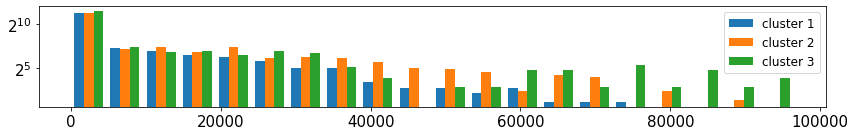

In [8]:
c0='0'
c1='3'
c3='2'
a0=232821
a1= 70938
a3= 190764
areasum=a0+a1+a3
a0=(areasum)/a0
a1=(areasum)/a1
a3=(areasum)/a3
s13='disease13'
# s13='disease13'
idx013=gaeclusterlabels[sampleNames==s13]==c0
idx113=gaeclusterlabels[sampleNames==s13]==c1
idx313=gaeclusterlabels[sampleNames==s13]==c3
# idx013=gaeclusterlabels[sampleNames==s13]==c0
# idx113=gaeclusterlabels[sampleNames==s13]==c1
res=[list(np.array(labellist[s13][idx013])+1),list(np.array(labellist[s13][idx313])+1),list(np.array(labellist[s13][idx113])+1)]
plt.rcParams["figure.figsize"] = (12,2)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
# numbers=plt.hist(res,20)
plt.yscale('log',base=2)
numbers13=plt.hist(res,bins=20,weights=[list(np.repeat(a0,np.array(labellist[s13][idx013]).size)),list(np.repeat(a3,np.array(labellist[s13][idx313]).size)),list(np.repeat(a1,np.array(labellist[s13][idx113]).size))])
plt.legend(['cluster 1','cluster 2','cluster 3'],fontsize=12)
# plt.xlabel('plaque size')
# plt.ylabel('log2 number of plaque')
plt.tight_layout()
plt.savefig(os.path.join(datadir,'plaqueDistr','plaqueDistr_logy_d13_wc3_areaNorm.tif'),dpi=300)

In [14]:
scipy.stats.ttest_ind(labellist[s13][idx013],labellist[s13][idx113],alternative='less')

Ttest_indResult(statistic=-5.739612006153623, pvalue=5.461251903777545e-09)

In [15]:
scipy.stats.ttest_ind(labellist[s13][idx013],labellist[s13][idx313],alternative='less')

Ttest_indResult(statistic=-7.7492499367843015, pvalue=6.39026192880456e-15)

In [16]:
scipy.stats.ttest_ind(labellist[s8][idx08],labellist[s8][idx18],alternative='less')

Ttest_indResult(statistic=-11.554435356257123, pvalue=1.5173949112641503e-30)

In [17]:
scipy.stats.ttest_ind(labellist[s8][idx08],labellist[s8][idx38],alternative='less')

Ttest_indResult(statistic=-0.8257439186758615, pvalue=0.20452096779951234)